# Task 1 Data Exploration

### Import Libraries and Load Dataset
Import necessary libraries and load the Yelp review dataset from Hugging Face's datasets library. The dataset is split into training data for initial exploration.

   label                                               text
0      4  I stalk this truck.  I've been to industrial p...
1      2  who really knows if this is good pho or not, i...
2      4  I LOVE Bloom Salon... all of their stylist are...
3      0  We were excited to eat here, it is difficult t...
4      2  So this is a place, with food. That much canno...
               label                                               text
count   12000.000000                                              12000
unique           NaN                                              12000
top              NaN  I stalk this truck.  I've been to industrial p...
freq             NaN                                                  1
mean        1.997250                                                NaN
std         1.424165                                                NaN
min         0.000000                                                NaN
25%         1.000000                                            

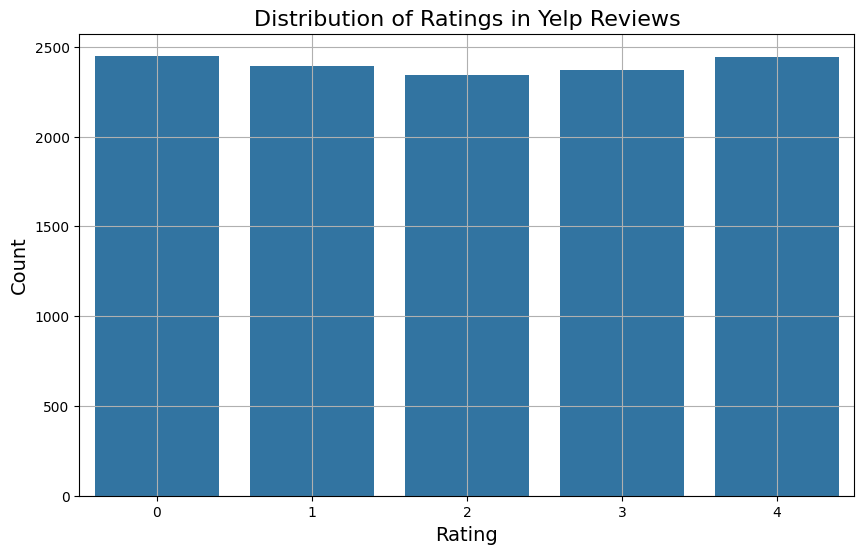

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset

# Load and prepare the Yelp review dataset
dataset = load_dataset('yelp_review_full', split='train')
yelp_df = dataset.shuffle(seed=42).select(range(12000)).to_pandas()

# Print the first five rows of the DataFrame to get a quick overview of the data
print(yelp_df.head())

# Explore the dataset with basic descriptive statistics
if not yelp_df.empty:
    print(yelp_df.describe(include='all'))  # Provides an overview including count, unique, top, freq for categorical data

# Visualize the distribution of review ratings
plt.figure(figsize=(10, 6))  # Increasing the figure size for better readability
sns.countplot(x='label', data=yelp_df)
plt.title('Distribution of Ratings in Yelp Reviews', fontsize=16)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(True)  # Add grid for better readability of the plot
plt.show()


### Text Length Analysis

Add a column for the length of each review. This could help in understanding if the length of a review correlates with its rating.

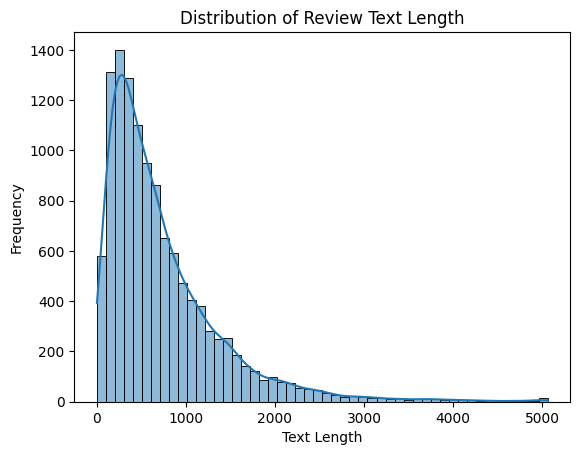

In [4]:
yelp_df['text_length'] = yelp_df['text'].apply(len)
sns.histplot(yelp_df['text_length'], bins=50, kde=True)
plt.title('Distribution of Review Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

### Compute correlation between label and text length
Compute and visualize the correlation between the review ratings ('label') and the length of the reviews ('text_length'). This is an insightful analysis as it can show if there's any relationship between the length of a review and its associated rating. 

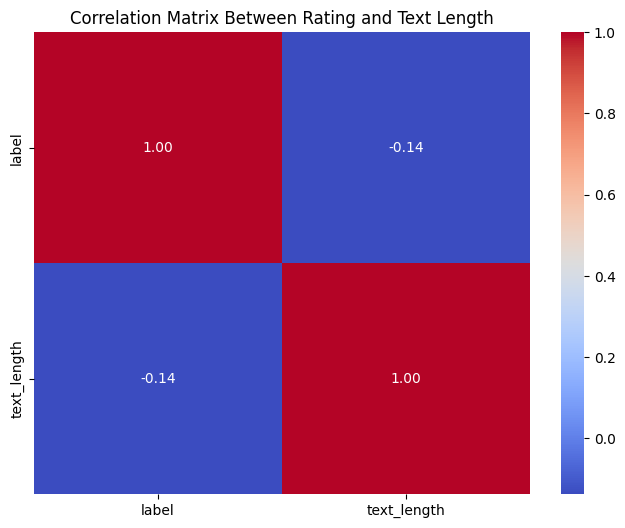

In [5]:
# Compute correlation between label and text length
correlation_matrix = yelp_df[['label', 'text_length']].corr()

# Visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Between Rating and Text Length')
plt.show()

# Task 2 Sentiment Analysis


### Prepare the Sentiment Analysis Models
Initialize three sentiment analysis pipelines, These models will analyze the sentiment of Yelp reviews and classify them into positive or negative sentiments.

In [6]:
from transformers import pipeline, AutoTokenizer

# Initialize sentiment analysis pipelines with fine-tuned models
pipelines = {
    'BERT-SST2': pipeline('sentiment-analysis', model='textattack/bert-base-uncased-SST-2'),
    'RoBERTa-SST2': pipeline('sentiment-analysis', model='textattack/roberta-base-SST-2'),
    'DistilBERT': pipeline('sentiment-analysis', model='distilbert-base-uncased-finetuned-sst-2-english')
}

Some weights of the model checkpoint at textattack/roberta-base-SST-2 were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Parallel Sentiment Analysis using Transformer Models
Define functions for sentiment analysis on large volumes of data using transformer-based models from the Hugging Face library. The use of multithreading to expedite processing and improve performance. 

In [7]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import os

def analyze_sentiment(pipeline, review):
    try:
        # Ensuring the text is string and handling possible truncation issues
        review = str(review)[:512] if len(review) > 512 else str(review)
        result = pipeline(review)[0]
        # Binary label based on the positive or negative prediction
        label = 'POSITIVE' if result['label'] == 'LABEL_1' or result['label'] == 'POSITIVE' else 'NEGATIVE' if result['label'] == 'LABEL_0' or result['label'] == 'NEGATIVE' else 'UNKNOWN'
        return {'label': label}
    except Exception as e:  
        return {'error': str(e), 'label': 'unknown'}

def process_reviews_in_parallel(reviews, pipeline_name, num_threads):
    pipeline = pipelines[pipeline_name]
    sentiments = [None] * len(reviews)
    errors = {}
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        future_to_index = {executor.submit(analyze_sentiment, pipeline, review): i for i, review in enumerate(reviews)}
        for future in as_completed(future_to_index):
            index = future_to_index[future]
            result = future.result()
            if 'error' in result:
                errors[index] = result['error']
            else:
                sentiments[index] = result['label']
    return sentiments, errors

# Applying multithreading to process sentiment analysis
num_threads = min(16, os.cpu_count())
print(f'Using {num_threads} threads for parallel processing')


Using 16 threads for parallel processing


Implement sentiment analysis of Yelp reviews across multiple pre-defined transformer-based models in parallel, leveraging multithreading to optimize the process.

In [8]:
# Process the sentiment analysis for each model
errors = {}
for model_name in pipelines:
    yelp_df[model_name], errors[model_name] = process_reviews_in_parallel(yelp_df['text'].tolist(), model_name, num_threads)
    print(f"Completed processing with {model_name}")

Completed processing with BERT-SST2
Completed processing with RoBERTa-SST2
Completed processing with DistilBERT


In [9]:
# display the first five rows of the yelp_df DataFrame
print(yelp_df.head())

   label                                               text  text_length  \
0      4  I stalk this truck.  I've been to industrial p...          328   
1      2  who really knows if this is good pho or not, i...          471   
2      4  I LOVE Bloom Salon... all of their stylist are...          390   
3      0  We were excited to eat here, it is difficult t...           95   
4      2  So this is a place, with food. That much canno...          674   

  BERT-SST2 RoBERTa-SST2 DistilBERT  
0  POSITIVE     POSITIVE   POSITIVE  
1  POSITIVE     POSITIVE   POSITIVE  
2  POSITIVE     POSITIVE   POSITIVE  
3  NEGATIVE     NEGATIVE   NEGATIVE  
4  POSITIVE     POSITIVE   POSITIVE  


### Adding Binary Sentiment Labels to Yelp Reviews Based on Star Ratings
This script enhances the Yelp review dataset by categorizing each review into 'POSITIVE' or 'NEGATIVE' based on its star rating. This binary classification is crucial for simplifying sentiment analysis and providing a clear baseline for comparing automated model predictions.

In [10]:
# Define a function to classify ratings based on stars
def classify_rating(row):
    return 'POSITIVE' if row['label'] >= 3 else 'NEGATIVE'
# Apply this function to classify reviews
yelp_df['binary_label'] = yelp_df.apply(classify_rating, axis=1)
print(yelp_df.head())

   label                                               text  text_length  \
0      4  I stalk this truck.  I've been to industrial p...          328   
1      2  who really knows if this is good pho or not, i...          471   
2      4  I LOVE Bloom Salon... all of their stylist are...          390   
3      0  We were excited to eat here, it is difficult t...           95   
4      2  So this is a place, with food. That much canno...          674   

  BERT-SST2 RoBERTa-SST2 DistilBERT binary_label  
0  POSITIVE     POSITIVE   POSITIVE     POSITIVE  
1  POSITIVE     POSITIVE   POSITIVE     NEGATIVE  
2  POSITIVE     POSITIVE   POSITIVE     POSITIVE  
3  NEGATIVE     NEGATIVE   NEGATIVE     NEGATIVE  
4  POSITIVE     POSITIVE   POSITIVE     NEGATIVE  


### Calculating and Comparing Model Accuracy for Sentiment Analysis on Yelp Reviews
This script evaluates the performance of different sentiment analysis models by comparing their predictions to manually classified binary sentiment labels based on Yelp review star ratings. It calculates the accuracy of each model and displays these metrics. 

In [11]:
from sklearn.metrics import accuracy_score
# Calculate the accuracy for each model and print results
for model_name in pipelines:
    accuracy = accuracy_score(yelp_df['binary_label'], yelp_df[model_name])
    print(f"Adjusted Accuracy of {model_name}: {accuracy:.2%}")

# Optionally, print any errors that occurred during processing to analyze further
print("Errors during sentiment analysis:", errors)

Adjusted Accuracy of BERT-SST2: 80.79%
Adjusted Accuracy of RoBERTa-SST2: 83.17%
Adjusted Accuracy of DistilBERT: 79.37%
Errors during sentiment analysis: {'BERT-SST2': {}, 'RoBERTa-SST2': {}, 'DistilBERT': {}}


### Evaluating and Visualizing Sentiment Analysis Model Performance on Yelp Reviews
Evaluate the performance of several sentiment analysis models by comparing their predictions against manually classified binary sentiment labels ('POSITIVE' or 'NEGATIVE') derived from Yelp review star ratings. it calculates accuracy, generates classification reports, confusion matrices, and visualizes the sentiment distribution for each model. Additionally, it checks for errors that occurred during the analysis process.


Model: BERT-SST2
Accuracy of BERT-SST2: 80.79%
Classification Report:
              precision    recall  f1-score   support

    NEGATIVE       0.90      0.76      0.83      7186
    POSITIVE       0.71      0.88      0.79      4814

    accuracy                           0.81     12000
   macro avg       0.81      0.82      0.81     12000
weighted avg       0.83      0.81      0.81     12000

Confusion Matrix:
[[4225  589]
 [1716 5470]]


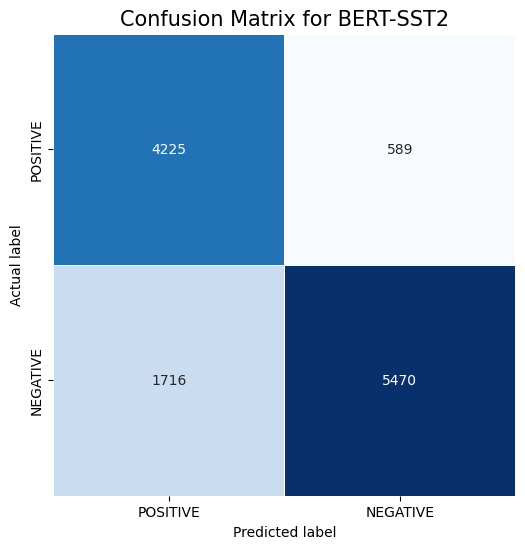

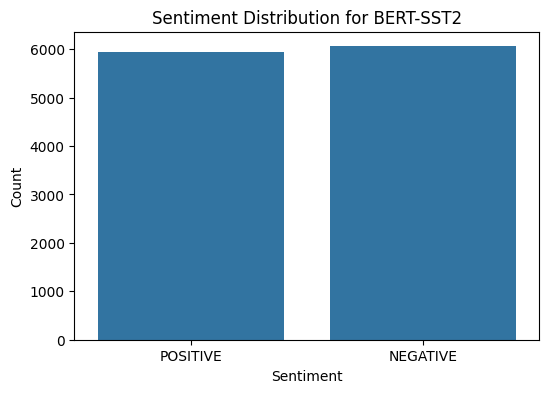


Model: RoBERTa-SST2
Accuracy of RoBERTa-SST2: 83.17%
Classification Report:
              precision    recall  f1-score   support

    NEGATIVE       0.94      0.77      0.85      7186
    POSITIVE       0.73      0.92      0.81      4814

    accuracy                           0.83     12000
   macro avg       0.83      0.85      0.83     12000
weighted avg       0.85      0.83      0.83     12000

Confusion Matrix:
[[4441  373]
 [1647 5539]]


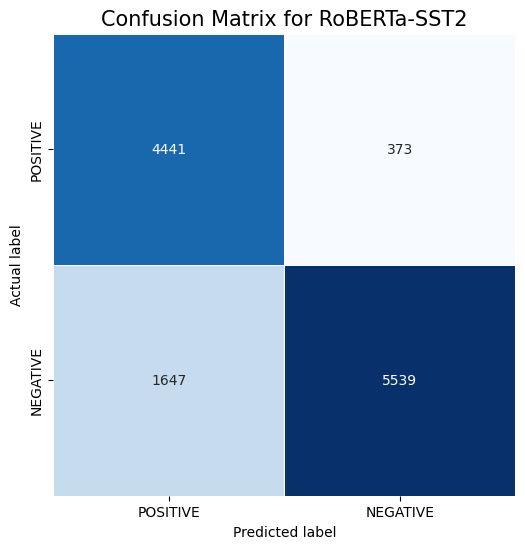

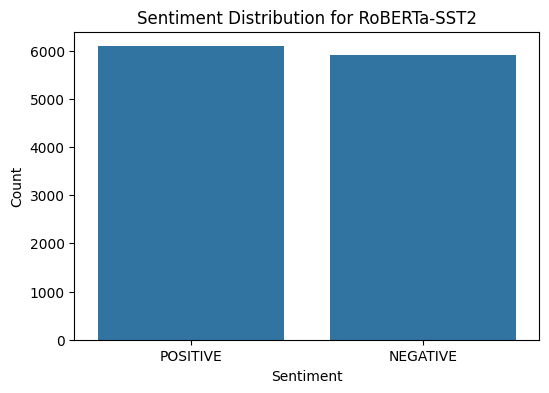


Model: DistilBERT
Accuracy of DistilBERT: 79.37%
Classification Report:
              precision    recall  f1-score   support

    NEGATIVE       0.89      0.74      0.81      7186
    POSITIVE       0.69      0.87      0.77      4814

    accuracy                           0.79     12000
   macro avg       0.79      0.81      0.79     12000
weighted avg       0.81      0.79      0.80     12000

Confusion Matrix:
[[4173  641]
 [1835 5351]]


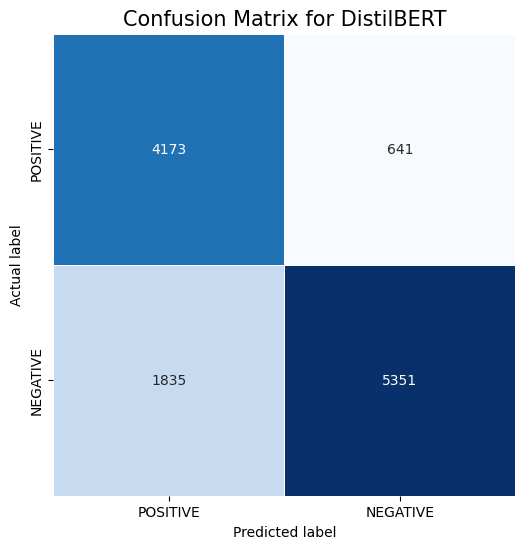

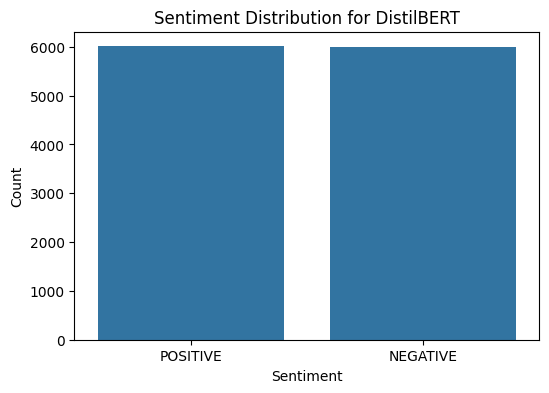

   label                                               text  text_length  \
0      4  I stalk this truck.  I've been to industrial p...          328   
1      2  who really knows if this is good pho or not, i...          471   
2      4  I LOVE Bloom Salon... all of their stylist are...          390   
3      0  We were excited to eat here, it is difficult t...           95   
4      2  So this is a place, with food. That much canno...          674   

  BERT-SST2 RoBERTa-SST2 DistilBERT binary_label  
0  POSITIVE     POSITIVE   POSITIVE     POSITIVE  
1  POSITIVE     POSITIVE   POSITIVE     NEGATIVE  
2  POSITIVE     POSITIVE   POSITIVE     POSITIVE  
3  NEGATIVE     NEGATIVE   NEGATIVE     NEGATIVE  
4  POSITIVE     POSITIVE   POSITIVE     NEGATIVE  


In [12]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the sentiment distribution for each model and calculating accuracy, classification report, and confusion matrix
for model_name in pipelines:
    print(f"\nModel: {model_name}")
    # Accuracy
    accuracy = accuracy_score(yelp_df['binary_label'], yelp_df[model_name])
    print(f"Accuracy of {model_name}: {accuracy:.2%}")

    # Classification Report
    print("Classification Report:")
    print(classification_report(yelp_df['binary_label'], yelp_df[model_name]))

    # Confusion Matrix
    cm = confusion_matrix(yelp_df['binary_label'], yelp_df[model_name], labels=['POSITIVE', 'NEGATIVE'])
    print("Confusion Matrix:")
    print(cm)

    # Plotting the confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square=True, cmap='Blues', cbar=False,
                xticklabels=['POSITIVE', 'NEGATIVE'], yticklabels=['POSITIVE', 'NEGATIVE'])
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title(f'Confusion Matrix for {model_name}', size=15)
    plt.show()

    # Sentiment Distribution Plot
    plt.figure(figsize=(6, 4))
    sns.countplot(x=yelp_df[model_name])
    plt.title(f'Sentiment Distribution for {model_name}')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.show()

# Check for any errors during processing
if any(errors.values()):
    print("Errors during sentiment analysis:", errors)

# Show DataFrame head
print(yelp_df.head())


### Visualizing Misclassifications Using Word Clouds
Visually represent the most frequent words found in misclassified Yelp reviews by sentiment analysis models.

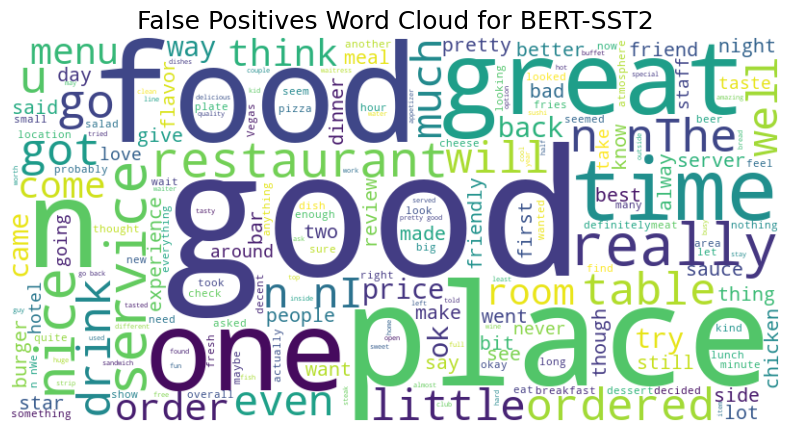

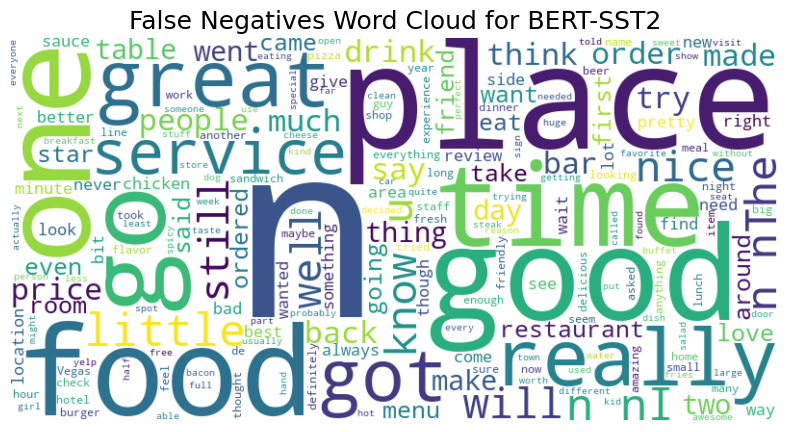

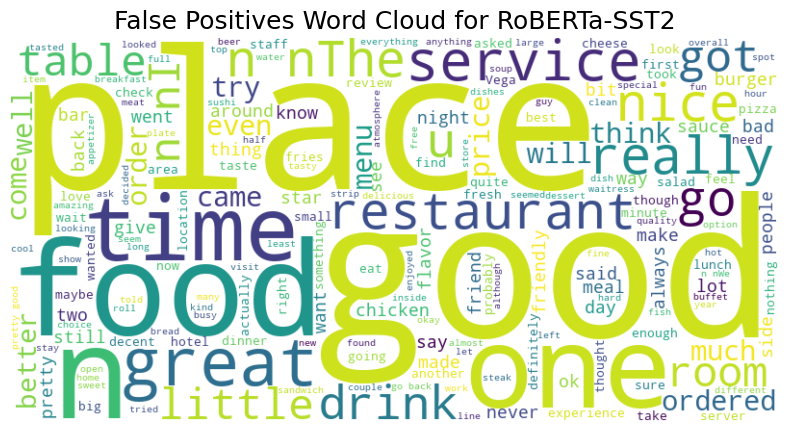

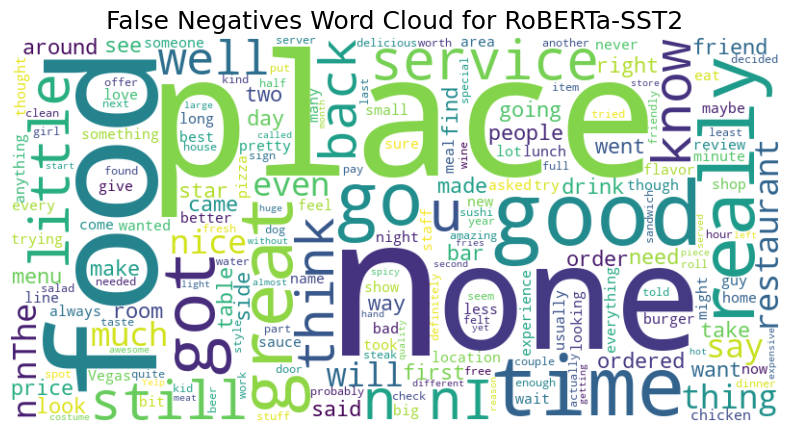

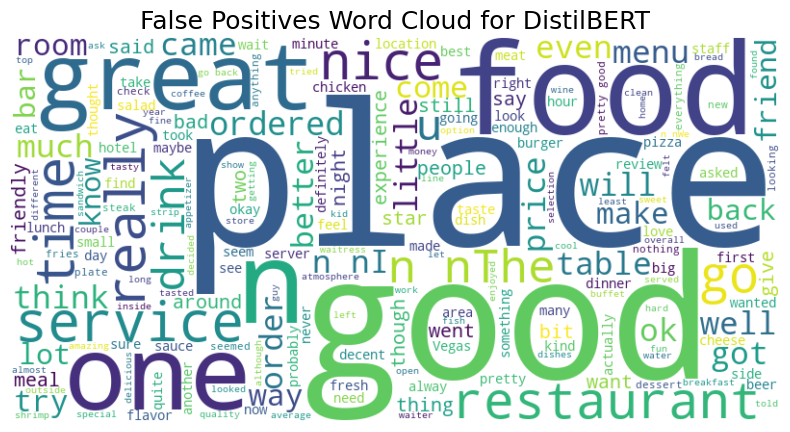

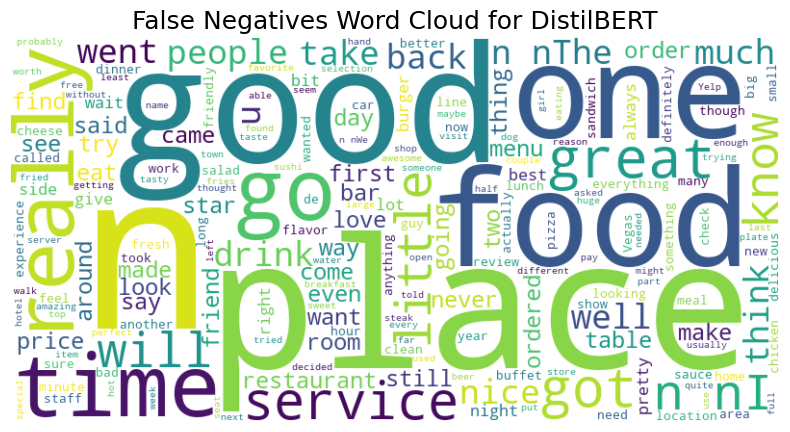

In [14]:
from wordcloud import WordCloud

def plot_word_cloud(texts, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(texts))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=18)
    plt.show()

# Identify misclassified reviews for each model and generate word clouds
for model_name in pipelines:
    false_positives_texts = yelp_df[(yelp_df['binary_label'] == 'NEGATIVE') & (yelp_df[model_name] == 'POSITIVE')]['text'].tolist()
    false_negatives_texts = yelp_df[(yelp_df['binary_label'] == 'POSITIVE') & (yelp_df[model_name] == 'NEGATIVE')]['text'].tolist()
    
    # Plot word clouds for false positives and false negatives
    plot_word_cloud(false_positives_texts, f'False Positives Word Cloud for {model_name}')
    plot_word_cloud(false_negatives_texts, f'False Negatives Word Cloud for {model_name}')


### Analyzing Model Performance by Sentiment Intensity
By categorizing Yelp reviews into low, medium, and high intensity based on their star ratings, it visualizes how each model (BERT, RoBERTa, and DistilBERT) predicts sentiments within these categories. 

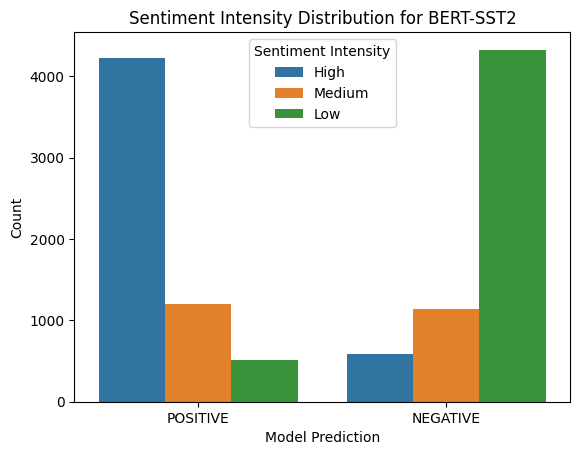

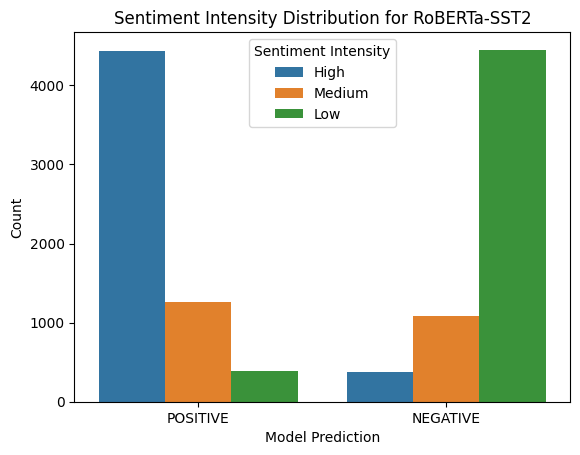

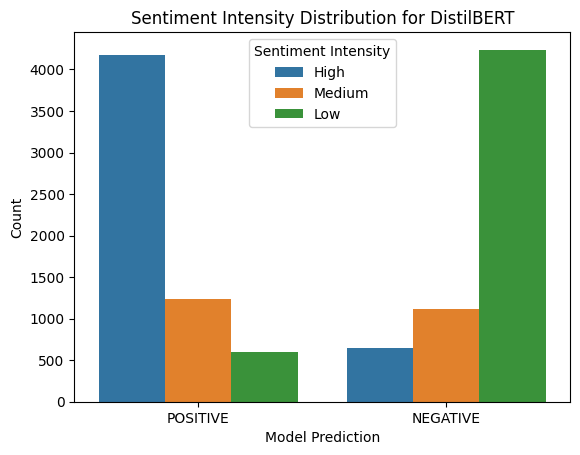

In [16]:
# Sentiment Intensity Analysis
def sentiment_intensity_analysis():
    # Creating a new column for sentiment intensity based on original ratings
    yelp_df['intensity'] = yelp_df['label'].apply(lambda x: 'Low' if x < 2 else 'Medium' if x == 2 else 'High')
    
    # Plotting model performance by sentiment intensity
    for model_name in pipelines:
        sns.countplot(x=yelp_df[model_name], hue=yelp_df['intensity'])
        plt.title(f'Sentiment Intensity Distribution for {model_name}')
        plt.xlabel('Model Prediction')
        plt.ylabel('Count')
        plt.legend(title='Sentiment Intensity')
        plt.show()

sentiment_intensity_analysis()

### Comparative Analysis of Sentiment Analysis Models Across Different Star Ratings
Evaluates the accuracy of different sentiment analysis models (BERT, RoBERTa, DistilBERT) across various star ratings of Yelp reviews. It calculates and visualizes the accuracy for each model by original star rating

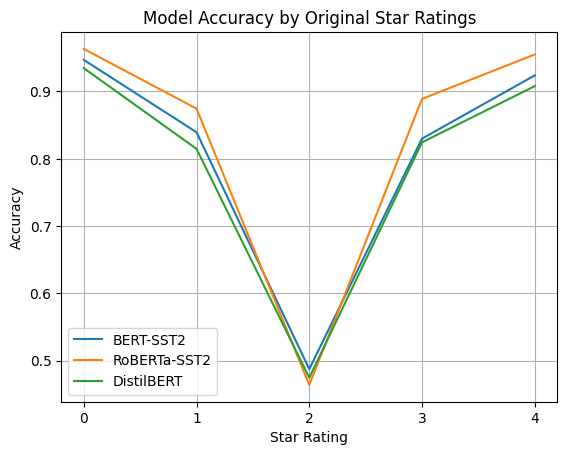

In [18]:
# Comparative accuracy across models by original star ratings
def comparative_accuracy_by_rating():
    ratings = sorted(yelp_df['label'].unique())
    accuracies = {model: [] for model in pipelines.keys()}
    
    for rating in ratings:
        subset = yelp_df[yelp_df['label'] == rating]
        for model in pipelines.keys():
            acc = accuracy_score(subset['binary_label'], subset[model])
            accuracies[model].append(acc)
    
    # Plotting
    for model, acc_list in accuracies.items():
        plt.plot(ratings, acc_list, label=model)
    
    plt.title('Model Accuracy by Original Star Ratings')
    plt.xlabel('Star Rating')
    plt.ylabel('Accuracy')
    plt.xticks(ratings)
    plt.legend()
    plt.grid(True)
    plt.show()

comparative_accuracy_by_rating()

# Task 3 Classification Tasks: Zero Shot Classification

### Summarize Reviews Using a Transformer Model
Use a transformer-based model like BART or T5 to summarize the reviews. This involves setting up a summarization pipeline using the Hugging Face transformers library.

In [110]:
from transformers import pipeline
from concurrent.futures import ThreadPoolExecutor, as_completed

# Load the summarization model
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

# Define a function to summarize reviews
def summarize_text(text):
    words = text.split()
    if len(words) > 1024:  # Assuming the model's token limit is around 1024
        text = ' '.join(words[:1024])  # Truncate to the first 1024 words
    max_len = min(1024, max(25, len(words) // 2))
    try:
        summary = summarizer(text, max_length=max_len, min_length=25, do_sample=False)
        return summary[0]['summary_text']
    except Exception as e:
        print(f"Error summarizing text: {e}")
        return text  # Return original text if summarization fails

# Function to apply summarization in parallel
def apply_summarization_concurrently(texts, num_threads=16):
    summaries = [None] * len(texts)  # Pre-allocate a list to hold the summaries
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        # Map each text to a separate thread in the pool
        future_to_index = {executor.submit(summarize_text, text): i for i, text in enumerate(texts)}
        
        # Collect results as they are completed
        for future in as_completed(future_to_index):
            index = future_to_index[future]
            try:
                summaries[index] = future.result()
            except Exception as exc:
                print(f'Text summarization at index {index} generated an exception: {exc}')
                summaries[index] = texts[index]  # Fallback to original text on failure
    return summaries


In [111]:
# Assuming yelp_df is already loaded and contains the reviews
# Select a random sample of 100 reviews for demonstration
sample_reviews = yelp_df.sample(n=100, random_state=42)

# Apply summarization to the sample
sample_reviews['summary'] = apply_summarization_concurrently(sample_reviews['text'].tolist(), num_threads=16)

# Calculate lengths of original texts and their summaries
sample_reviews['text_length'] = sample_reviews['text'].apply(len)
sample_reviews['summary_length'] = sample_reviews['summary'].apply(len)

# Display the original texts, their summaries, star ratings, and lengths
print(sample_reviews[['text', 'summary', 'label', 'text_length', 'summary_length']])

Your max_length is set to 25, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 25, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)
Your max_length is set to 25, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 25, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_l

                                                    text  \
1935   Much better than the last time we saw him at t...   
6494   I was going to tell a long story, but the basi...   
1720   Straight up looks like Matrix Reloaded in here...   
9120   Every now and again I make my way to Von's for...   
360    Like any fast food place, the staff changes of...   
...                                                  ...   
2019   Let me say this up front:  I **LOVE** Chipotle...   
9836   Last night's attempt at dining at Vito's will ...   
11351  The food is good, but I just cannot get past h...   
6702   Service was poor, and all orders came out wron...   
4029   I am giving the Sheep Camp 3 stars based on th...   

                                                 summary  label  text_length  \
1935   He is really rough with language and comments ...      2          572   
6494   The check-out clerk's parting remark to me was...      0          365   
1720   It's intimate, the dance floor i

### Setting Up the Rating Prediction Function
You have the predict_rating function already defined. Now, we will apply it to the summaries using multithreading.

In [112]:
# Load the sentiment analysis model
rating_predictor = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

# Define a function to predict star ratings based on summaries
def predict_star_ratings(summaries, num_threads=16):
    ratings = [None] * len(summaries)  # Pre-allocate the list for ratings
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        future_to_index = {executor.submit(rating_predictor, summary): i for i, summary in enumerate(summaries)}
        for future in as_completed(future_to_index):
            index = future_to_index[future]
            try:
                result = future.result()
                # Extract the first character of the label, convert to integer and adjust for 1 to 5 scale
                ratings[index] = int(result[0]['label'][0]) - 1
            except Exception as exc:
                print(f'Rating prediction at index {index} generated an exception: {exc}')
                ratings[index] = None  # Fallback to None on failure
    return ratings


### Predict Star Ratings Using Summaries
After summarizing the reviews, the next step is to predict their star ratings. use a classification model that's been trained on text data to predict ratings, such as a fine-tuned BERT or RoBERTa model specifically adjusted for rating predictions.

In [113]:
# Assume you have the summaries ready in `sample_reviews['summary']`
predicted_ratings = predict_star_ratings(sample_reviews['summary'].tolist())

# Add these adjusted ratings to the DataFrame
sample_reviews['predict_rating'] = predicted_ratings

# Display the DataFrame to check the new column with predicted ratings
print(sample_reviews[['text', 'summary', 'label', 'predict_rating']])

                                                    text  \
1935   Much better than the last time we saw him at t...   
6494   I was going to tell a long story, but the basi...   
1720   Straight up looks like Matrix Reloaded in here...   
9120   Every now and again I make my way to Von's for...   
360    Like any fast food place, the staff changes of...   
...                                                  ...   
2019   Let me say this up front:  I **LOVE** Chipotle...   
9836   Last night's attempt at dining at Vito's will ...   
11351  The food is good, but I just cannot get past h...   
6702   Service was poor, and all orders came out wron...   
4029   I am giving the Sheep Camp 3 stars based on th...   

                                                 summary  label  \
1935   He is really rough with language and comments ...      2   
6494   The check-out clerk's parting remark to me was...      0   
1720   It's intimate, the dance floor is packed and t...      3   
9120   Von'

### Classification Report for Yelp Review Ratings
This classification report provides detailed metrics including precision, recall, and F1-score for each star rating, helping assess the sentiment analysis model's accuracy in predicting Yelp review ratings based on their content.

In [114]:
from sklearn.metrics import classification_report

# Assuming 'label' and 'predict_rating' are both in integer form
report = classification_report(sample_reviews['label'], sample_reviews['predict_rating'], target_names=[str(i) for i in range(1, 6)])
print(report)


              precision    recall  f1-score   support

           1       0.71      0.60      0.65        20
           2       0.44      0.44      0.44        16
           3       0.29      0.23      0.26        22
           4       0.25      0.23      0.24        22
           5       0.50      0.75      0.60        20

    accuracy                           0.44       100
   macro avg       0.44      0.45      0.44       100
weighted avg       0.43      0.44      0.43       100



### Visualizing Prediction Accuracy for Yelp Reviews
This visualization set includes a confusion matrix and density plot comparing actual and predicted Yelp review ratings, revealing the model's accuracy and highlighting areas where prediction improvements are needed. The plots illustrate discrepancies and alignment between predicted and true customer sentiments.

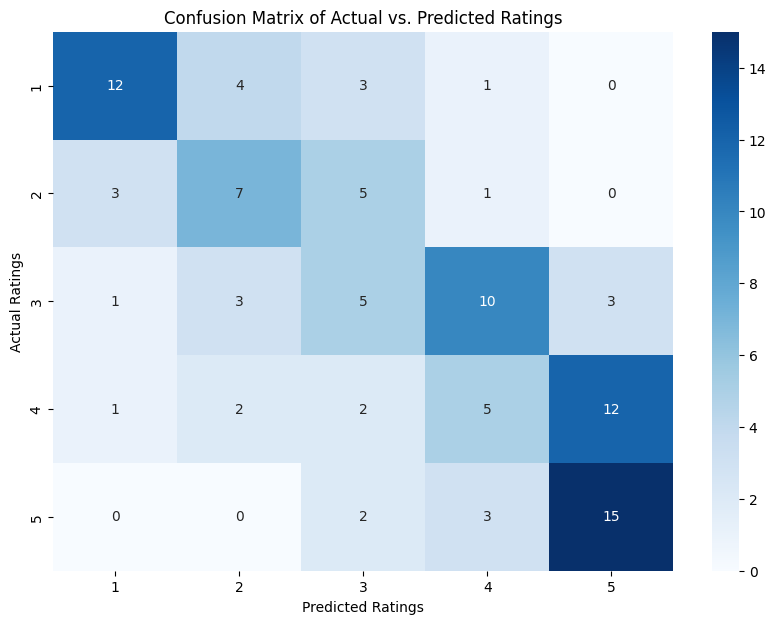

C:\Users\52347\AppData\Local\Temp\ipykernel_34272\1155380682.py:25: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(sample_reviews['label'], fill=True, common_norm=False, palette="crest", label='Actual Ratings', alpha=0.5)
C:\Users\52347\AppData\Local\Temp\ipykernel_34272\1155380682.py:26: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(sample_reviews['predict_rating'].fillna(0).astype(int), fill=True, common_norm=False, palette="crest", label='Predicted Ratings', alpha=0.5)


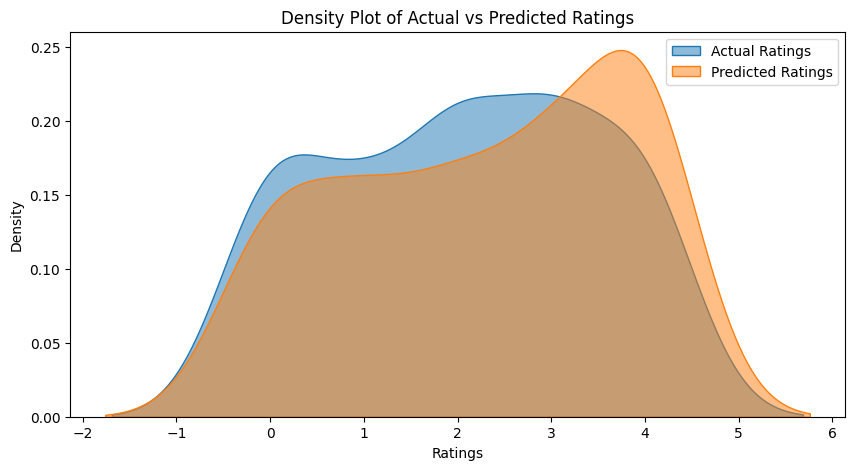

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Example DataFrame preparation
# Make sure your DataFrame `sample_reviews` has 'label' and 'predict_rating' with appropriate data
# sample_reviews = pd.DataFrame({
#     'label': [1, 2, 3, 4, 5, 2, 1],  # Actual ratings
#     'predict_rating': [1, 2, 3, 5, 4, 2, 1]  # Predicted ratings
# })

# Plotting the Confusion Matrix
cm = confusion_matrix(sample_reviews['label'], sample_reviews['predict_rating'].fillna(0).astype(int))
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.title('Confusion Matrix of Actual vs. Predicted Ratings')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

# Comparing Actual vs Predicted Ratings
plt.figure(figsize=(10, 5))
sns.kdeplot(sample_reviews['label'], fill=True, common_norm=False, palette="crest", label='Actual Ratings', alpha=0.5)
sns.kdeplot(sample_reviews['predict_rating'].fillna(0).astype(int), fill=True, common_norm=False, palette="crest", label='Predicted Ratings', alpha=0.5)
plt.title('Density Plot of Actual vs Predicted Ratings')
plt.xlabel('Ratings')
plt.legend()
plt.show()


### Zero-Shot Classification of Yelp Reviews Using BART and T5 Models
This script utilizes the zero-shot classification capabilities of BART and T5 models to categorize Yelp reviews into predefined categories such as Restaurants, Hotels, and more. The results, including predicted categories for each model, are integrated into a DataFrame and displayed, showcasing the effectiveness of each model in understanding and classifying review content.

In [116]:
from transformers import pipeline

# Load the zero-shot classification models
bart_classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
t5_classifier = pipeline("zero-shot-classification", model="t5-base")

# Candidate classes
candidate_labels = [
    "Restaurants", "Bars", "Coffee Shops", "Hotels", "Salons/Barbershops",
    "Auto Repair", "Home Services", "Medical Services", "Entertainment", "Pet Services",
    "Financial Services", "Travel & Tourism", "Education", "Real Estate", "Fitness",
    "Landscaping & Gardening Services", "Legal Services", "Photography Services",
    "Childcare Services", "Computer & Technology Services"
]

# Function to classify reviews using BART and T5
def classify_reviews(reviews, bart_classifier, t5_classifier):
    bart_results = []
    t5_results = []  # Placeholder for T5 results if adapted
    for review in reviews:
        # BART classification
        try:
            bart_result = bart_classifier(review, candidate_labels=candidate_labels, multi_label=False)
            bart_results.append(bart_result["labels"][0])
        except Exception as e:
            print(f"Error with BART classification: {e}")
            bart_results.append(None)

        # T5 classification
        try:
            # T5 requires a different kind of prompt setup, you would adapt here
            t5_result = t5_classifier("Classify the following review: " + review, candidate_labels=candidate_labels, multi_label=False)
            t5_results.append(t5_result["labels"][0])
        except Exception as e:
            print(f"Error with T5 classification: {e}")
            t5_results.append(None)

    return bart_results, t5_results

# Classify reviews
sample_reviews['BART_Class'] = classify_reviews(sample_reviews['text'].tolist(), bart_classifier, t5_classifier)[0]
sample_reviews['T5_Class'] = classify_reviews(sample_reviews['text'].tolist(), bart_classifier, t5_classifier)[1]

# Display results
print(sample_reviews[['text', 'BART_Class', 'T5_Class']])


Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at t5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Python311\Lib\site-packages\transformers\models\t5\tokenization_t5_fast.py:160: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/pad

                                                    text     BART_Class  \
1935   Much better than the last time we saw him at t...           Bars   
6494   I was going to tell a long story, but the basi...  Entertainment   
1720   Straight up looks like Matrix Reloaded in here...  Entertainment   
9120   Every now and again I make my way to Von's for...  Entertainment   
360    Like any fast food place, the staff changes of...    Restaurants   
...                                                  ...            ...   
2019   Let me say this up front:  I **LOVE** Chipotle...    Restaurants   
9836   Last night's attempt at dining at Vito's will ...    Restaurants   
11351  The food is good, but I just cannot get past h...    Restaurants   
6702   Service was poor, and all orders came out wron...    Restaurants   
4029   I am giving the Sheep Camp 3 stars based on th...    Restaurants   

                               T5_Class  
1935     Computer & Technology Services  
6494           

### GPT-2 Based Zero-Shot Classification of Yelp Reviews
This Python script demonstrates the use of GPT-2 for zero-shot text classification by evaluating the perplexity of potential categories for Yelp reviews. The results are added to a DataFrame, allowing comparison of GPT-2's predictions with those from BART and T5 models, illustrating its unique approach to understanding context through generative capabilities.

In [117]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
    
def zero_shot_classification_gpt2(text, candidate_labels, model_name='gpt2'):
    # Load tokenizer and model
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    model = GPT2LMHeadModel.from_pretrained(model_name)

    # Encode text and each label as input to GPT-2
    text_encoding = tokenizer.encode(text, return_tensors='pt')
    
    min_perplexity = float('Inf')
    best_label = None

    # Check each label
    for label in candidate_labels:
        # Encode label and get combined encoding with text
        label_encoding = tokenizer.encode(' ' + label, return_tensors='pt')
        combined_encoding = torch.cat((text_encoding, label_encoding), dim=1)
        
        # Calculate loss but do not backpropagate
        with torch.no_grad():
            outputs = model(combined_encoding, labels=combined_encoding)
            logits = outputs.logits

        # Calculate perplexity
        shift_logits = logits[:, :-1, :].contiguous()
        shift_labels = combined_encoding[:, 1:].contiguous()
        loss = torch.nn.CrossEntropyLoss()(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        perplexity = torch.exp(loss)

        # Check if this label has the lowest perplexity so far
        if perplexity < min_perplexity:
            min_perplexity = perplexity
            best_label = label

    return best_label

# Apply GPT-2 classification to each review in the DataFrame
sample_reviews['GPT2_Class'] = sample_reviews['text'].apply(lambda x: zero_shot_classification_gpt2(x, candidate_labels))

# Display the DataFrame to check the new column with GPT-2 predictions
print(sample_reviews[['text', 'BART_Class', 'T5_Class', 'GPT2_Class']])

                                                    text     BART_Class  \
1935   Much better than the last time we saw him at t...           Bars   
6494   I was going to tell a long story, but the basi...  Entertainment   
1720   Straight up looks like Matrix Reloaded in here...  Entertainment   
9120   Every now and again I make my way to Von's for...  Entertainment   
360    Like any fast food place, the staff changes of...    Restaurants   
...                                                  ...            ...   
2019   Let me say this up front:  I **LOVE** Chipotle...    Restaurants   
9836   Last night's attempt at dining at Vito's will ...    Restaurants   
11351  The food is good, but I just cannot get past h...    Restaurants   
6702   Service was poor, and all orders came out wron...    Restaurants   
4029   I am giving the Sheep Camp 3 stars based on th...    Restaurants   

                               T5_Class                        GPT2_Class  
1935     Computer & Tec

### Output to csv for further manual categories

In [123]:
# Check if all the required columns are present
required_columns = ['text', 'BART_Class', 'T5_Class', 'GPT2_Class']
if all(column in sample_reviews.columns for column in required_columns):
    # Specify the file path and name for the CSV file
    output_file_path = 'D:/CS learning/NEU/CS6120/A4/class_output.csv'  # Modify the path as needed

    # Save the DataFrame to CSV
    sample_reviews[required_columns].to_csv(output_file_path, index=False)
    print(f"Data successfully saved to {output_file_path}")
else:
    missing_columns = [column for column in required_columns if column not in sample_reviews.columns]
    print(f"Missing columns in DataFrame that are required for export: {missing_columns}")


Data successfully saved to D:/CS learning/NEU/CS6120/A4/class_output.csv
